In [10]:
# Import modules

import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt


In [60]:
# Load data
# data = pd.read_csv('data.csv')
data = pd.read_csv('data\planning_historic_actuals.csv')
data_52wks = data[(data['MeasureID'] == 1013) &
                  (data['RegionCode'] == "Y59")]

# Unpivot data
data_52wks = pd.melt(data_52wks, id_vars=data_52wks.columns[1:7], value_vars=data_52wks.columns[8:])

# Rename month column, filter error months, and set data type to date
data_52wks.rename(columns={'variable': 'date'}, inplace=True)
data_52wks = data_52wks.loc[data_52wks['date'].str.len() == 6]
data_52wks['date'] = pd.to_datetime(data_52wks['date'], format='%b-%y')

data_52wks.head()

,OrgType,ICBCode,RegionCode,MeasureID,MeasureName,MeasureType,date,value
0,Provider,QRL,Y59,1013.0,RTT Waiting List,Total 52 plus weeks,2023-05-01,893.0
1,Provider,QXU,Y59,1013.0,RTT Waiting List,Total 52 plus weeks,2023-05-01,2830.0
2,Provider,QNQ,Y59,1013.0,RTT Waiting List,Total 52 plus weeks,2023-05-01,6255.0
3,Provider,QRL,Y59,1013.0,RTT Waiting List,Total 52 plus weeks,2023-05-01,2191.0
4,Provider,QRL,Y59,1013.0,RTT Waiting List,Total 52 plus weeks,2023-05-01,1964.0


In [61]:
# Load plan data
plan = pd.read_csv('data/plans.csv')

plan = plan[plan['planning_ref'] == "E.B.24"]

data_52wks_plan = plan.groupby(['dimension_name']).agg({'numerator': 'sum'}).reset_index()
data_52wks_plan = data_52wks_plan.rename(columns={'dimension_name': 'date', 'numerator': 'plan'})
data_52wks_plan['date'] = pd.to_datetime(data_52wks_plan['date'], format='%d/%m/%Y')

data_52wks_plan.head()

,date,plan
0,2026-01-01,4128.0
1,2026-02-01,3359.0
2,2026-03-01,3093.0
3,2025-04-01,7819.0
4,2025-05-01,7741.0


In [80]:
# Sum value to region total
data_52wks_actual = data_52wks.groupby('date')['value'].sum().reset_index()

# Remove 'zero' data
data_52wks_actual = data_52wks_actual[data_52wks_actual['value'] != 0]

In [78]:
# merge data
data_52wks_forecast = pd.merge(data_52wks_actual, data_52wks_plan, on='date', how='outer')

data_52wks_forecast.head()

,date,value,plan
0,2023-05-01,47709.0,NaN
1,2023-06-01,49167.0,NaN
2,2023-07-01,51816.0,NaN
3,2023-08-01,54047.0,NaN
4,2023-09-01,54137.0,NaN


In [74]:
print(data_52wks_forecast.columns)

Index(['date', 'value', 'plan'], dtype='object')


In [84]:
data_52wks_forecast = data_52wks_actual

c:\Users\martin.bloyce2\AppData\Local\anaconda3\envs\hsma_forecast\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


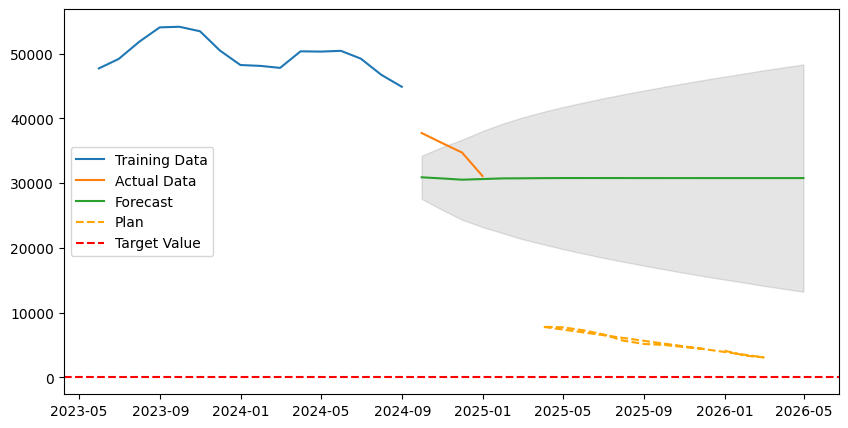

Probability of hitting the target by 2026-03-31: 0.00%
Last date in training data: 2024-08-31 00:00:00


In [85]:

# Ensure the date column is parsed as datetime and set as index
# data_52wks_forecast['date'] = pd.to_datetime(data_52wks_forecast['date'])
data_52wks_forecast = data_52wks_forecast.set_index('date')

# Ensure data is in monthly frequency
data_52wks_forecast = data_52wks_forecast.resample('M').mean()

# Select the column to use for ARIMA model
endog = data_52wks_forecast['value']

# Define the target date and value
target_date = '2026-03-31'
target_value = 100

# Split data into training and testing sets
train = data_52wks_forecast[:int(0.8*len(data_52wks_forecast))]
test = data_52wks_forecast[int(0.8*len(data_52wks_forecast)):]

# Fit ARIMA model
model = ARIMA(endog, order=(5,1,0))
model_fit = model.fit()

# Forecast up to the target date
forecast_steps = len(pd.date_range(start=train.index[-1], end=target_date, freq='M'))
forecast_result = model_fit.get_forecast(steps=forecast_steps)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Create a date range for the forecast
forecast_index = pd.date_range(start=train.index[-1], periods=forecast_steps + 1, freq='M')[1:]

# Plot forecast with confidence intervals
plt.figure(figsize=(10,5))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Data')
plt.plot(forecast_index, forecast, label='Forecast')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='k', alpha=0.1)
# Plot the plan data from data_52wks_plan
plt.plot(data_52wks_plan['date'], data_52wks_plan['plan'], label='Plan', color='orange', linestyle='--')

plt.axhline(y=target_value, color='r', linestyle='--', label='Target Value')
# plt.plot(data_52wks_forecast.index, data_52wks_forecast['plan'], label='Plan', color='orange')
plt.legend()
plt.show()

# Calculate probability of hitting target on the target date
target_conf_int = conf_int.iloc[-1]  # Confidence interval on the target date
probability = np.mean((target_conf_int[0] <= target_value) & (target_conf_int[1] >= target_value))
print(f'Probability of hitting the target by {target_date}: {probability*100:.2f}%')

print("Last date in training data:", train.index[-1])